# Project NASA T anomaly onto population

- Use the NASA GISS temperature anomaly to get the exposure over a long period.
- Problem is we don't have population pre 2000. Might be reasonable to back-interpolate at least to 1990, growth can be approximated to linear over that kind of time scale it seems.
- 

In [9]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import rasterio
import matplotlib.pyplot as plt
from rasterio.io import MemoryFile
from rasterio.warp import reproject, Resampling
from affine import Affine
from tqdm import tnrange, tqdm_notebook


import population_tools
from config import DATA_SRC, POP_DATA_SRC


In [2]:
nasa_giss_anom = DATA_SRC / 'weather' / 'nasa_giss' / 'air.2x2.1200.mon.anom.comb.nc'

In [3]:
nasa_giss = xr.open_dataset(str(nasa_giss_anom))
nasa_giss = nasa_giss.rename({'lon':'longitude', 'lat':'latitude'})
nasa_giss

<xarray.Dataset>
Dimensions:    (latitude: 90, longitude: 180, time: 1647)
Coordinates:
  * latitude   (latitude) float32 89.0 87.0 85.0 83.0 81.0 79.0 77.0 75.0 ...
  * longitude  (longitude) float32 1.0 3.0 5.0 7.0 9.0 11.0 13.0 15.0 17.0 ...
  * time       (time) datetime64[ns] 1880-01-01 1880-02-01 1880-03-01 ...
Data variables:
    air        (time, latitude, longitude) float64 nan nan nan nan nan nan ...
Attributes:
    title:          GISS Surface Temperature Analysis (GISTEMP): 1200km smoot...
    comments:       This is the 1200km smoothed combined land,ocean version o...
    platform:       Analysis
    Source:         http://data.giss.nasa.gov/gistemp/ source and http://data...
    Documentation:  http://www.esrl.noaa.gov/psd/data/gridded/data.gistemp.html
    references:     http://www.esrl.noaa.gov/psd/data/gridded/data.gistemp.html
    Conventions:    COARDS
    history:        created at PSD Jun 2009 by CAS. Converted to chunked, def...
    dataset_title:  GISS Surface T

In [11]:
def collect_summer_delta(delta_t):
    """Wrap in a function to clear temporary vars from memory"""
    # northern hemisphere
    lat_north = delta_t.latitude[delta_t.latitude >= 0]
    lat_south = delta_t.latitude[delta_t.latitude < 0]

    # Summer North
    summer_jja = delta_t['time.season'] == 'JJA'

    # Summer South
    summer_djf = delta_t['time.season'] == 'DJF'

    nh = delta_t.sel(time=summer_jja).groupby('time.year').mean(dim='time')
    sh = delta_t.sel(time=summer_djf).groupby('time.year').mean(dim='time')

    summer_anom = xr.concat([nh.sel(latitude=lat_north),  
                             sh.sel(latitude=lat_south)], dim='latitude')
    return summer_anom

summer_anom = collect_summer_delta(nasa_giss)

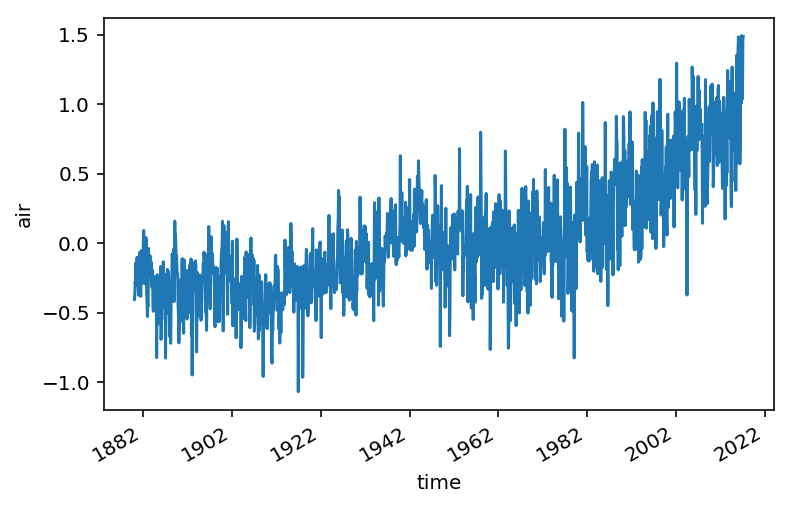

In [15]:
nasa_giss.mean(dim=['latitude', 'longitude']).air.plot()

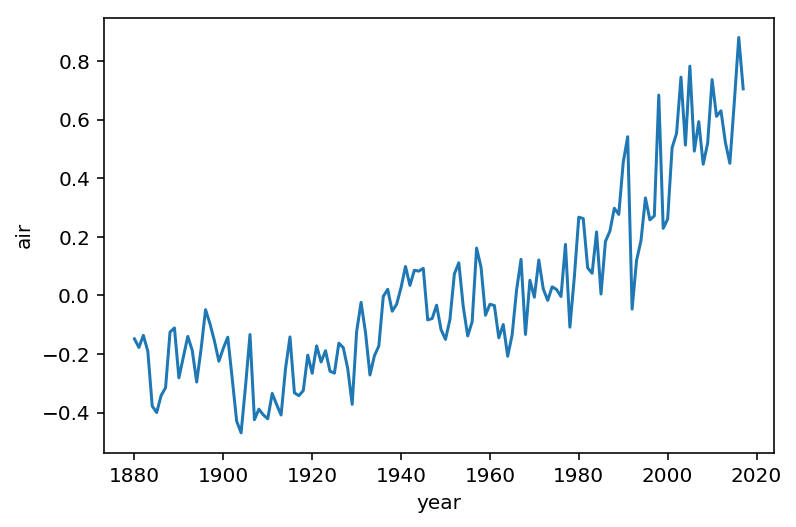

In [14]:
summer_anom.mean(dim=['latitude', 'longitude']).air.plot()

In [6]:
# temperature = nasa_giss.air.groupby('time.year').mean(dim='time')

In [16]:
target = xr.open_dataset(str(POP_DATA_SRC / 'histsoc_population_0.5deg_1861-2005.nc'),                         )


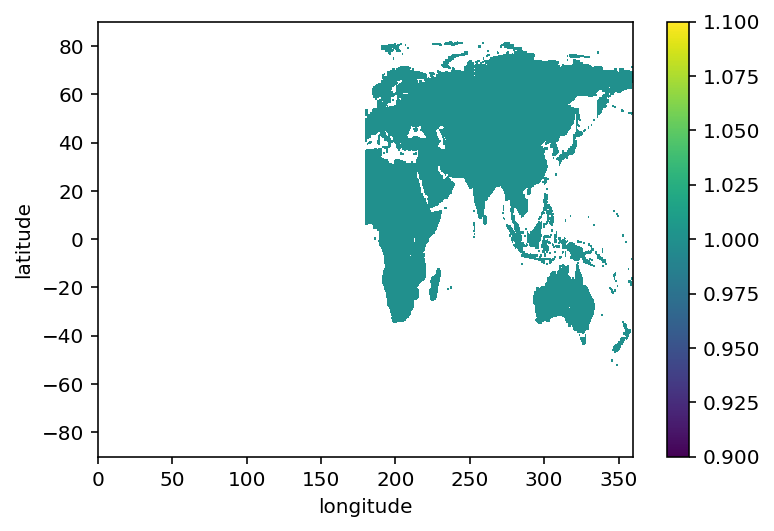

In [22]:
with population_tools.PopulationProjector('histsoc_population_0.5deg_1861-2005_.nc', mask_empty=False) as pop:
    da = xr.DataArray(pop.water_mask, coords=[pop.data.latitude, pop.data.longitude])
    da.plot()


In [101]:
with population_tools.PopulationProjector('histsoc_population_0.5deg_1861-2005.nc') as pop:
    pop_mean = pop.data.mean(dim=['latitude', 'longitude'])
    pop_sum = pop.data.sum(dim=['latitude', 'longitude'])


    def _gen():
        for year in tnrange(2000,2017):
            yield pop.project(year, summer_anom.sel(year=year))

    summer_exposures = xr.concat(_gen(), dim='year')   


2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015


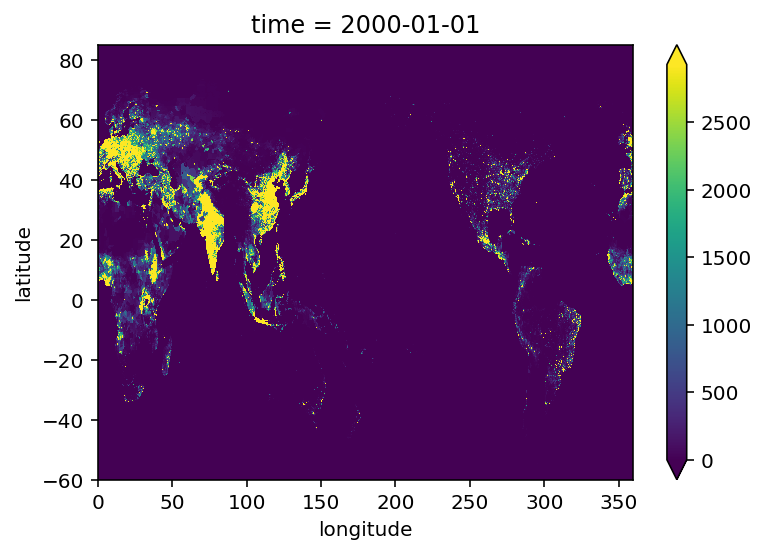

In [98]:
yr_exposures[0].plot(robust=True)

In [102]:
yr_exposures = xr.concat(yr_exposures, dim='time')
yr_exposures.name = 'year_mean_exposure'

In [105]:
yr_exposures.to_netcdf(str(DATA_SRC / 'lancet' / 'nasa_giss_yr_exposure.nc'))